### 建立一个简单的 聊天机器人 图

In [1]:
from typing import Any, Annotated
from pydantic import BaseModel, Field
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.tools import BaseTool
from langchain.chat_models import ChatOpenAI

from typing_extensions import TypedDict

from langgraph.graph import StateGraph #StateGraph: 用来存储状态和动作的图
from langgraph.graph.message import add_messages #add_messages: 用来添加消息到图中

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("api_key")
base_url = os.getenv("base_url")

online_llm = ChatOpenAI(
    model='qwen-plus',
    temperature=0,
    api_key=api_key,
    base_url=base_url,
)


In [ ]:

#State类: 用来存储状态和动作的字典
'''
1、​​Annotated 的作用​​：这是 Python 的 typing 模块提供的工具，允许在类型提示中附加元数据（metadata）。此处：
list 表示 messages 字段的类型是列表（存储消息对象）。
add_messages 是一个函数，用于定义​​如何更新该列表​​（元数据）。
2. ​​状态管理的自动化​​
​​add_messages 的功能​​：该函数在 LangGraph 中用于智能管理对话历史：
​​自动合并消息​​：当节点返回新消息时，框架会自动将新消息列表与旧列表合并（而非覆盖）。
​​去重与更新​​：若新消息中存在与旧消息相同的 ID（例如消息被修改），则替换旧消息。
​​支持流式处理​​：适用于聊天机器人等需要维护完整对话历史的场景。
'''
class State(TypedDict):
    messages: Annotated[list, add_messages]


#初始化 状态图
graph_builder = StateGraph(State)


#节点函数定义
def chatbot(state: State):
    return {"messages": [online_llm.invoke(state["messages"])]}


'''
add_node：添加节点（名称+处理函数）
set_entry_point：设置入口节点
set_finish_point：设置终止节点
'''
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

#编译图:生成可执行的状态图
graph = graph_builder.compile()

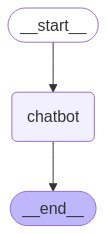

In [8]:
#显示 当前状态图 的节点和边
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


Assistant: 你好！今天过得怎么样？
Assistant: 我在和你聊天呀。今天过得怎么样？有什么我可以帮你的吗？比如解答问题、写故事、玩游戏等等。
Goodbye!
